In [26]:
import os
import pickle
import sys
sys.path.append("../")

import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics

from openbustools import data_utils, plotting

In [11]:
model_res = pickle.load(open("../results/kcm/FF.pkl", 'rb'))

In [15]:
for fold_num, experiment_res in model_res.items():
    for experiment_name, preds_and_labels in experiment_res.items():
        print(metrics.mean_absolute_percentage_error(preds_and_labels['labels'], preds_and_labels['preds']))


3845.17
3949.025
0.3674625
3763.362
4322.295
0.36827886
523434880000000.0
683335940000000.0
0.42199054
507685370000000.0
646864000000000.0
0.39408222
550692050000000.0
614383860000000.0
0.42561212


In [27]:
def regression_results(labels, preds):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(labels, preds)
    mean_absolute_error=metrics.mean_absolute_error(labels, preds) 
    mse=metrics.mean_squared_error(labels, preds) 
    mean_squared_log_error=metrics.mean_squared_log_error(labels, preds)
    median_absolute_error=metrics.median_absolute_error(labels, preds)
    r2=metrics.r2_score(labels, preds)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [35]:
np.min(model_res[4]['same_city']['labels'])

0.0

In [31]:
np.max(model_res[0]['same_city']['preds'])

2455.917

ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

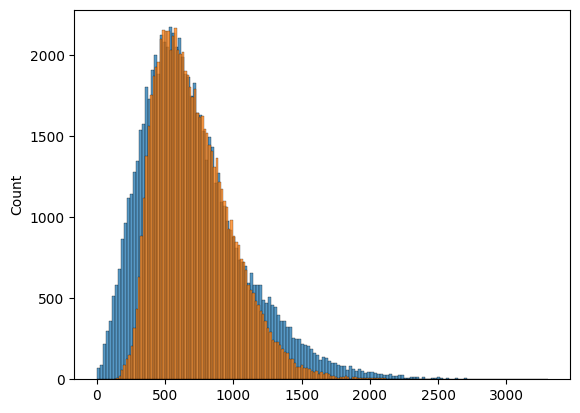

In [28]:
axes = sns.histplot(model_res[0]['same_city']['labels'])
sns.histplot(model_res[0]['same_city']['preds'], ax=axes)
regression_results(model_res[0]['same_city']['labels'], model_res[0]['same_city']['preds'])

In [ ]:
run_folder_kcm = "../results/big_run/kcm/models/"
run_folder_atb = "../results/big_run/atb/models/"
run_folder_mix = "../results/big_run_nosch/kcm_atb/models/"
run_folder_rut = "../results/big_run_nosch/rut/models/"

In [ ]:
# Hyperparam results per network:
# CONV (128, 64, 3, 0.1)
# FF (128, 128, 2, 0.2)
# GRU (128, 64, 2, 0.05)
# TRSF (128, 64, 3, 0.1)

# KCM
# 512, 16, 2, 0.4 (TRSF)
# 512, 16, 5, 0.1
# 512, 128, 4, 0.4
# 128, 128, 2, 0.2 (FF)
# 128, 128, 2, 0.05 (GRU, CONV)
# 512, 16, 4, 0.2
# 1024, 16, 4, 0.1

# Model Epochs TestLoss
# CONV_0	10.000000	18.066327
# FF_0	11.333333	168.559759
# GRU_0	16.000000	18.540478
# TRSF_0	10.000000	22.919503

# CONV_0	10.000000	17.851481
# FF_0	11.333333	157.528422
# GRU_0	10.000000	22.917446
# TRSF_0	10.000000	22.915722

# CONV_0	12.0	15.852690
# FF_0	14.0	153.020960
# GRU_0	10.0	22.916604
# TRSF_0	10.0	22.912308

# CONV_0	12.8	15.829175
# FF_0	38.8	137.929590
# GRU_0	10.0	16.677470
# TRSF_0	10.0	22.853009

# CONV_1	12.8	15.750058
# FF_1	38.0	138.345676
# GRU_1	10.0	16.506545
# TRSF_1	10.0	22.851783

# CONV_0	10.0	17.629307
# FF_0	11.0	158.601257
# GRU_0	10.0	22.885823
# TRSF_0	10.0	22.888074

# CONV_1	10.0	18.191666
# FF_1	13.0	157.479233
# GRU_1	10.0	22.871649
# TRSF_1	10.0	22.862472


# AtB
# 512, 32, 3, 0.2
# 512, 32, 5, 0.4
# 512, 16, 2, 0.4
# 128, 32, 4, 0.2
# 128, 64, 5, 0.05 (CONV, FF, GRU, TRSF)

# CONV_0	12.666667	7.069618
# FF_0	19.333333	63.465285
# GRU_0	17.333333	9.175895
# TRSF_0	16.000000	9.075986

# CONV_0	12.000000	6.991179
# FF_0	18.000000	67.876277
# GRU_0	16.666667	9.161330
# TRSF_0	20.000000	9.001094

# CONV_0	14.000000	7.567914
# FF_0	23.333333	66.901993
# GRU_0	20.000000	9.058873
# TRSF_0	16.000000	9.404305

# CONV_0	10.8	6.135663
# FF_0	17.2	63.238688
# GRU_0	11.6	8.897823
# TRSF_0	11.6	8.895937

# CONV_1	10.0	6.058242
# FF_1	19.2	60.404724
# GRU_1	10.0	8.898676
# TRSF_1	10.8	8.893464

In [ ]:
# Need to combine model results for all models
model_list = [x for x in os.listdir(run_folder_kcm) if (x[-3:]!="pkl" and x!=".DS_Store")]
all_model_results = []
all_model_times = []
all_model_gen_results = []
for i, m in enumerate(model_list):
    training_results = data_utils.load_pkl(f"{run_folder_kcm}{m}/model_results.pkl")
    results_df, time_df = data_utils.extract_results(training_results, "Seattle")
    if m[-4:]!="GRID":
        gen_results = data_utils.load_pkl(f"{run_folder_kcm}{m}/model_generalization_results.pkl")
        gen_df = data_utils.extract_gen_results(gen_results, "Seattle")
    if i!=0:
        results_df = results_df[results_df['Model']==m]
        time_df = time_df[time_df['Model']==m]
        gen_df = gen_df[gen_df['Model']==m]
    all_model_results.append(results_df)
    all_model_times.append(time_df)
    all_model_gen_results.append(gen_df)
kcm_result_df = pd.concat(all_model_results).sort_values(["Model","Fold"])
kcm_time_df = pd.concat(all_model_times).sort_values(["Model","Fold"])
kcm_gen_df = pd.concat(all_model_gen_results).sort_values(["Model","Fold"])
kcm_baseline_df = kcm_gen_df[kcm_gen_df['Loss']=="Train_Losses"].copy()
kcm_baseline_df['Loss'] = "Network Baseline"
kcm_baseline_df = kcm_baseline_df[['Model','City','Loss','Fold','MAPE','RMSE','MAE']]

# Need to combine model results for all models
model_list = [x for x in os.listdir(run_folder_atb) if (x[-3:]!="pkl" and x!=".DS_Store")]
all_model_results = []
all_model_times = []
all_model_gen_results = []
for i, m in enumerate(model_list):
    training_results = data_utils.load_pkl(f"{run_folder_atb}{m}/model_results.pkl")
    results_df, time_df = data_utils.extract_results(training_results, "Trondheim")
    if m[-4:]!="GRID":
        gen_results = data_utils.load_pkl(f"{run_folder_atb}{m}/model_generalization_results.pkl")
        gen_df = data_utils.extract_gen_results(gen_results, "Trondheim")
    if i!=0:
        results_df = results_df[results_df['Model']==m]
        time_df = time_df[time_df['Model']==m]
        gen_df = gen_df[gen_df['Model']==m]
    all_model_results.append(results_df)
    all_model_times.append(time_df)
    all_model_gen_results.append(gen_df)
atb_result_df = pd.concat(all_model_results).sort_values(["Model","Fold"])
atb_time_df = pd.concat(all_model_times).sort_values(["Model","Fold"])
atb_gen_df = pd.concat(all_model_gen_results).sort_values(["Model","Fold"])
atb_baseline_df = atb_gen_df[atb_gen_df['Loss']=="Train_Losses"].copy()
atb_baseline_df['Loss'] = "Network Baseline"
atb_baseline_df = atb_baseline_df[['Model','City','Loss','Fold','MAPE','RMSE','MAE']]

### Model Performance

In [ ]:
print(kcm_gen_df[kcm_gen_df['Loss']=="Train_Losses"].groupby(["Model"])[["MAPE"]].agg(["mean","std"]))

In [ ]:
print(kcm_result_df.groupby(["Model"])[["MAPE"]].agg(["mean","std"]))

In [ ]:
plot_data = kcm_result_df
fig, axes = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(8)
sns.barplot(plot_data, x="MAPE", y="Model", ax=axes)
axes.set_xlim([0, 0.5])
fig.suptitle('KCM Model Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_performances_kcm.eps", format='eps', dpi=600, bbox_inches='tight')
plt.savefig("../plots/model_performances_kcm.png", format='png', dpi=600, bbox_inches='tight')

In [ ]:
print(atb_gen_df[atb_gen_df['Loss']=="Train_Losses"].groupby(["Model"])[["MAPE"]].agg(["mean","std"]))

In [ ]:
print(atb_result_df.groupby(["Model"])[["MAPE"]].agg(["mean","std"]))

In [ ]:
plot_data = atb_result_df
fig, axes = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(8)
sns.barplot(plot_data, x="MAPE", y="Model", ax=axes)
axes.set_xlim([0, 0.5])
fig.suptitle('AtB Model Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_performances_atb.eps", format='eps', dpi=600, bbox_inches='tight')
plt.savefig("../plots/model_performances_atb.png", format='png', dpi=600, bbox_inches='tight')

### Generalization (Across Networks)

In [ ]:
plot_data = atb_gen_df[atb_gen_df['Loss']=="Test_Losses"].copy()
plot_data = pd.concat([plot_data, kcm_baseline_df])
plot_data = plot_data[~plot_data['Model'].isin(["AVG","SCH","PER_TIM"])]
plot_data['Loss'] = plot_data['Loss'].replace(["Test_Losses"],["Model Trained on AtB"])
fig, axes = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(8)
sns.barplot(plot_data, x="MAPE", y="Model", hue="Loss", dodge=True)
axes.set_xlim([0,.5])
axes.set_ylabel("Model")
axes.set_xlabel("Model Performance (MAPE)")
fig.suptitle('KCM Network Generalization Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_generalization_kcm.eps", format='eps', dpi=600, bbox_inches='tight')
plt.savefig("../plots/model_generalization_kcm.png", format='png', dpi=600, bbox_inches='tight')

In [ ]:
plot_data = kcm_gen_df[kcm_gen_df['Loss']=="Test_Losses"].copy()
plot_data = pd.concat([plot_data, atb_baseline_df])
plot_data = plot_data[~plot_data['Model'].isin(["AVG","SCH","PER_TIM"])]
plot_data['Loss'] = plot_data['Loss'].replace(["Test_Losses"],["Model Trained on KCM"])
fig, axes = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(8)
sns.barplot(plot_data, x="MAPE", y="Model", hue="Loss", dodge=True)
axes.set_xlim([0, .5])
axes.set_ylabel("Model")
axes.set_xlabel("Model Performance (MAPE)")
fig.suptitle('AtB Network Generalization Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_generalization_atb.eps", format='eps', dpi=600, bbox_inches='tight')
plt.savefig("../plots/model_generalization_atb.png", format='png', dpi=600, bbox_inches='tight')

### Generalization (Within Network)

In [ ]:
plot_data = kcm_gen_df[kcm_gen_df['Loss']=="Holdout_Losses"].copy()
plot_data = pd.concat([plot_data, kcm_baseline_df])
plot_data = plot_data[~plot_data['Model'].isin(["AVG","SCH","PER_TIM"])]
plot_data['Loss'] = plot_data['Loss'].replace(["Holdout_Losses"],["Holdout Routes"])
fig, axes = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(8)
sns.barplot(plot_data, x="MAPE", y="Model", hue="Loss", dodge=True)
axes.set_xlim([0, .5])
axes.set_ylabel("Model")
axes.set_xlabel("Model Performance (MAPE)")
fig.suptitle('KCM Network Holdout Route Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_holdout_route_kcm.eps", format='eps', dpi=600, bbox_inches='tight')
plt.savefig("../plots/model_holdout_route_kcm.png", format='png', dpi=600, bbox_inches='tight')

In [ ]:
plot_data = atb_gen_df[atb_gen_df['Loss']=="Holdout_Losses"].copy()
plot_data = pd.concat([plot_data, atb_baseline_df])
plot_data = plot_data[~plot_data['Model'].isin(["AVG","SCH","PER_TIM"])]
plot_data['Loss'] = plot_data['Loss'].replace(["Holdout_Losses"],["Holdout Routes"])
fig, axes = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(8)
sns.barplot(plot_data, x="MAPE", y="Model", hue="Loss", dodge=True)
axes.set_xlim([0, .5])
axes.set_ylabel("Model")
axes.set_xlabel("Model Performance (MAPE)")
fig.suptitle('AtB Network Holdout Route Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_holdout_route_atb.eps", format='eps', dpi=600, bbox_inches='tight')
plt.savefig("../plots/model_holdout_route_atb.png", format='png', dpi=600, bbox_inches='tight')

### Fine Tuning

In [ ]:
plot_data = atb_gen_df[atb_gen_df['Loss'].isin(['Tune_Test_Losses','Test_Losses'])]
plot_data = pd.concat([plot_data, kcm_baseline_df])
plot_data = plot_data[~plot_data['Model'].isin(["AVG","SCH","PER_TIM"])]
plot_data['Loss'] = plot_data['Loss'].replace(["Tune_Test_Losses","Test_Losses"],["Model Trained on AtB + Tuning", "Model Trained on AtB"])
fig, axes = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(8)
sns.barplot(plot_data, x="MAPE", y="Model", hue="Loss", dodge=True)
axes.set_xlim([0, .5])
axes.set_ylabel("Model")
axes.set_xlabel("Model Performance (MAPE)")
fig.suptitle('KCM Tuned Network Generalization Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_tuning_kcm.eps", format='eps', dpi=600, bbox_inches='tight')
plt.savefig("../plots/model_tuning_kcm.png", format='png', dpi=600, bbox_inches='tight')

In [ ]:
plot_data = kcm_gen_df[kcm_gen_df['Loss'].isin(['Tune_Test_Losses','Test_Losses'])]
plot_data = pd.concat([plot_data, atb_baseline_df])
plot_data = plot_data[~plot_data['Model'].isin(["AVG","SCH","PER_TIM"])]
plot_data['Loss'] = plot_data['Loss'].replace(["Tune_Test_Losses","Test_Losses"],["Model Trained on KCM + Tuning", "Model Trained on KCM"])
fig, axes = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(8)
sns.barplot(plot_data, x="MAPE", y="Model", hue="Loss", dodge=True)
axes.set_xlim([0, .5])
axes.set_ylabel("Model")
axes.set_xlabel("Model Performance (MAPE)")
fig.suptitle('AtB Tuned Network Generalization Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_tuning_atb.eps", format='eps', dpi=600, bbox_inches='tight')
plt.savefig("../plots/model_tuning_atb.png", format='png', dpi=600, bbox_inches='tight')

In [ ]:
plot_data = kcm_gen_df[kcm_gen_df['Loss']=="Tune_Train_Losses"]
plot_data = pd.concat([plot_data, kcm_baseline_df])
plot_data = plot_data[~plot_data['Model'].isin(["AVG","SCH","PER_TIM"])]
plot_data['Loss'] = plot_data['Loss'].replace(["Tune_Train_Losses"],["KCM Model Tuned on AtB"])
fig, axes = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(8)
sns.barplot(plot_data, x="MAPE", y="Model", hue="Loss", dodge=True)
axes.set_xlim([0,.5])
axes.set_ylabel("Model")
axes.set_xlabel("Model Performance (MAPE)")
fig.suptitle('KCM Network Deterioration', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_deterioration_kcm.eps", format='eps', dpi=600, bbox_inches='tight')
plt.savefig("../plots/model_deterioration_kcm.png", format='png', dpi=600, bbox_inches='tight')

In [ ]:
plot_data = atb_gen_df[atb_gen_df['Loss']=="Tune_Train_Losses"]
plot_data = pd.concat([plot_data, atb_baseline_df])
plot_data = plot_data[~plot_data['Model'].isin(["AVG","SCH","PER_TIM"])]
plot_data['Loss'] = plot_data['Loss'].replace(["Tune_Train_Losses"],["AtB Model Tuned on KCM"])
fig, axes = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(8)
sns.barplot(plot_data, x="MAPE", y="Model", hue="Loss", dodge=True)
axes.set_xlim([0,.5])
axes.set_ylabel("Model")
axes.set_xlabel("Model Performance (MAPE)")
fig.suptitle('AtB Network Deterioration', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_deterioration_atb.eps", format='eps', dpi=600, bbox_inches='tight')
plt.savefig("../plots/model_deterioration_atb.png", format='png', dpi=600, bbox_inches='tight')

### Mixed Data

In [ ]:
# Need to combine model results for all models
model_list = [x for x in os.listdir(run_folder_mix) if (x[-3:]!="pkl" and x!=".DS_Store")]
all_model_results = []
all_model_times = []
all_model_gen_results = []
for i, m in enumerate(model_list):
    training_results = data_utils.load_pkl(f"{run_folder_mix}{m}/model_results.pkl")
    results_df, time_df = data_utils.extract_results(training_results, "Mixed")
    if m[-4:]!="GRID":
        gen_results = data_utils.load_pkl(f"{run_folder_kcm}{m}/model_generalization_results.pkl")
        gen_df = data_utils.extract_gen_results(gen_results, "Mixed")
    if i!=0:
        results_df = results_df[results_df['Model']==m]
        time_df = time_df[time_df['Model']==m]
        gen_df = gen_df[gen_df['Model']==m]
    all_model_results.append(results_df)
    all_model_times.append(time_df)
    all_model_gen_results.append(gen_df)
mix_result_df = pd.concat(all_model_results).sort_values(["Model","Fold"])
mix_time_df = pd.concat(all_model_times).sort_values(["Model","Fold"])
mix_gen_df = pd.concat(all_model_gen_results).sort_values(["Model","Fold"])

mix_baseline_df = mix_gen_df[mix_gen_df['Loss']=="Train_Losses"].copy()
mix_baseline_df['Loss'] = "Network Baseline"
mix_baseline_df = mix_baseline_df[['Model','City','Loss','Fold','MAPE','RMSE','MAE']]

In [ ]:
plot_data = mix_gen_df[mix_gen_df['Loss']=="Test_Losses"].copy()
plot_data = pd.concat([plot_data, mix_baseline_df])
plot_data['Loss'] = plot_data['Loss'].replace(["Test_Losses"],["Tested on Ruter"])
plot_data['Loss'] = plot_data['Loss'].replace(["Network Baseline"],["Tested on Mixed KCM/AtB"])
plot_data = plot_data[~plot_data['Model'].isin(["AVG","SCH","PER_TIM"])]
fig, axes = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(8)
sns.barplot(plot_data, x="MAPE", y="Model", hue="Loss", dodge=True)
axes.set_xlim([0,.5])
axes.set_ylabel("Model")
axes.set_xlabel("Model Performance (MAPE)")
fig.suptitle('KCM/AtB Mixed Models Generalization Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_generalization_mix.eps", format='eps', dpi=600, bbox_inches='tight')
plt.savefig("../plots/model_generalization_mix.png", format='png', dpi=600, bbox_inches='tight')